# Muon residual dE/dx

This tutorial is an example of how to use the output of the full chain (specifically, track clustering predictions) to make a muon residual dE/dx plot. We will adopt a simple approach:

1. Select predicted track instances.
2. Use PCA to find a global direction for each predicted track.
3. Break down each track into segments of ~5cm long. Select tracks that are >60cm long and that do not stop near (<10cm) the volume boundaries (using true endpoints).
4. Among the tracks, select true muons.
5. Fit a local PCA to each track segment found so far. This will define the local dx. Sum up charge to get dQ.
6. Optionally, we can refine the residual range computation by iterating through the segments starting from the endpoint and summing the local dx lengths.

NB: as a reminder, for conversion, one voxel equals 3mm^3 in our sample.

In [1]:
import numpy as np
import yaml
import torch
import pandas as pd
from tqdm.notebook import tqdm, trange

# 3D visualization
import plotly
import plotly.graph_objs as go


# 2D plotting
import matplotlib
from matplotlib import pyplot as plt
import seaborn
seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk') # or paper

Download `lartpc_mlreco3d` and setup the package

In [2]:
![ -d lartpc_mlreco3d ] || git clone https://github.com/DeepLearnPhysics/lartpc_mlreco3d
! cd lartpc_mlreco3d && git checkout workshop && git pull

Already on 'workshop'
Your branch is up to date with 'origin/workshop'.
Already up to date.


In [3]:
import sys, os
# set software directory
software_dir = 'lartpc_mlreco3d'
sys.path.insert(0,software_dir)

In [4]:
from mlreco.visualization import scatter_points, plotly_layout3d
from mlreco.visualization.gnn import scatter_clusters, network_topology, network_schematic
from mlreco.utils.ppn import uresnet_ppn_type_point_selector
from mlreco.main_funcs import process_config, prepare
from mlreco.utils.gnn.cluster import get_cluster_label, get_cluster_batch
from mlreco.visualization.gnn import network_topology
from mlreco.utils.gnn.cluster import form_clusters
from mlreco.utils.gnn.evaluation import primary_assignment

from larcv import larcv

/usr/local/lib/python3.8/dist-packages/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


Welcome to JupyROOT 6.22/09


## Running the full chain on a small sample

(To save space, I am capturing the output of initializing the config below)

You can set the batch size according to your computing resources.

In [5]:
cfg = open('./workshop.cfg', 'r')
yaml_cfg=yaml.load(cfg,Loader=yaml.Loader)

batch_size = 8
yaml_cfg['iotool']['batch_size'] = batch_size
yaml_cfg['iotool']['sampler']['batch_size'] = batch_size
yaml_cfg['model']['modules']['chain']['verbose'] = False

In [6]:
%%capture

# pre-process configuration (checks + certain non-specified default settings)
process_config(yaml_cfg)
# prepare function configures necessary "handlers"
hs=prepare(yaml_cfg)

In [7]:
# Call forward to run the net, store the output in "output"
data, output = hs.trainer.forward(hs.data_io_iter)

We will demonstrate on one entry the process of breaking down track particle instances into smaller fragments along their principal axis. You can pick an entry index in [0, batch_size], preferably one that has several tracks.

In [8]:
entry = 0

## Track particles instances

In [9]:
clust_label = data['cluster_label'][entry]
input_data = data['input_data'][entry]
particles = data['particles_asis'][entry]

The GNN clustering stage of the full chain predicts track cluster instances. They are accessible under `output['track_fragments']`. To visualize the predictions along with the truth labels, we need to retrieve the majority true cluster label for each predicted track, which we do with the utility function `get_cluster_label`:

In [10]:
clust_ids_true = get_cluster_label(data['cluster_label'][entry], output['track_fragments'][entry], column=6)
clust_ids_pred = output['track_group_pred'][entry]

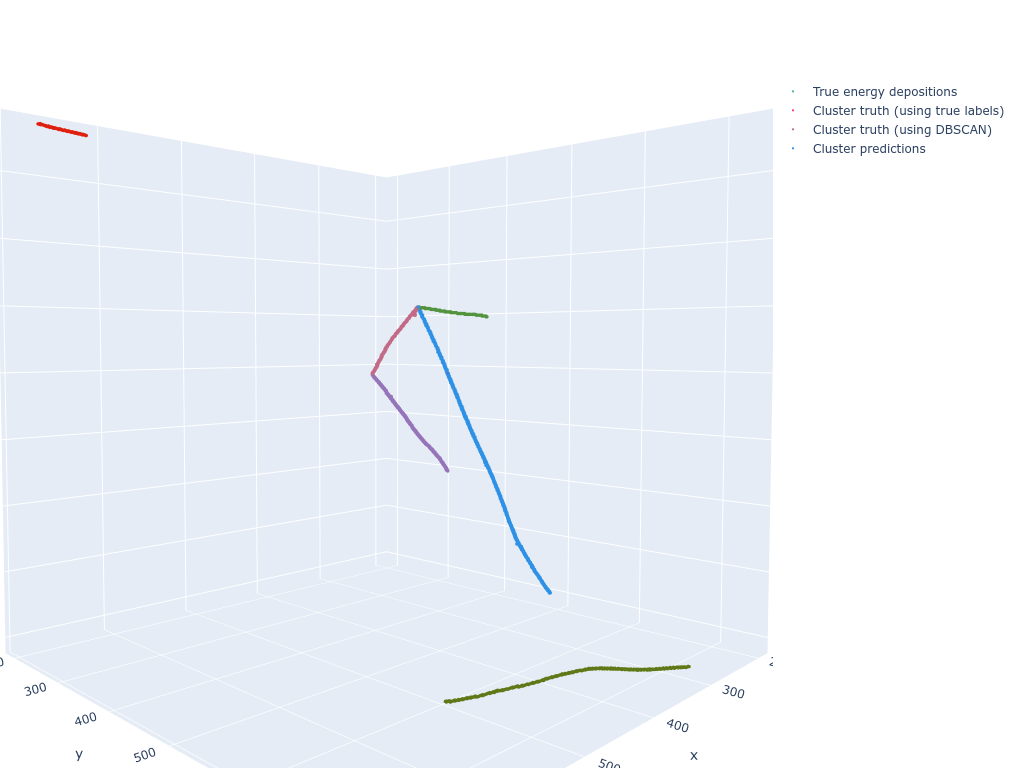

In [14]:
trace = []

trace+= scatter_points(clust_label[clust_label[:, -1] == 1],markersize=1,color=input_data[:, 4][clust_label[:, -1] == 1], cmin=0, cmax=1, colorscale=plotly.colors.sequential.Viridis)
trace[-1].name = 'True energy depositions'

trace+= scatter_points(clust_label[clust_label[:, -1] == 1],markersize=1,color=clust_label[:, 6][clust_label[:, -1] == 1], colorscale=plotly.colors.qualitative.Dark24)
trace[-1].name = 'Cluster truth (using true labels)'

trace += network_topology(data['input_data'][entry],
                         output['track_fragments'][entry],
                         #edge_index=output['frag_edge_index'][entry],
                         clust_labels=clust_ids_true,
                         markersize=2, cmin=0, cmax=40, colorscale=plotly.colors.qualitative.Dark24)
trace[-1].name = 'Cluster truth (using DBSCAN)'

trace += network_topology(data['input_data'][entry],
                         output['track_fragments'][entry],
                         #edge_index=output['frag_edge_index'][entry],
                         clust_labels=clust_ids_pred,
                         markersize=2, cmin=0, cmax=40, colorscale=plotly.colors.qualitative.Dark24)
trace[-1].name = 'Cluster predictions'

fig = go.Figure(data=trace,layout=plotly_layout3d())
fig.update_layout(legend=dict(x=1., y=0.9))
fig.show()

## Define track principal axis

PCA is an easy way to determine a rough direction for a track-like particle trajectory.

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

axis = []
for f in output['track_fragments'][entry]:
    coords = input_data[f, 1:4]
    new_coords = pca.fit_transform(coords)
    new_coords[:, 1:] = 0.
    x = pca.inverse_transform(new_coords)
    axis.append(x)

We can draw these principal axis to make sure it is consistent with the tracks:

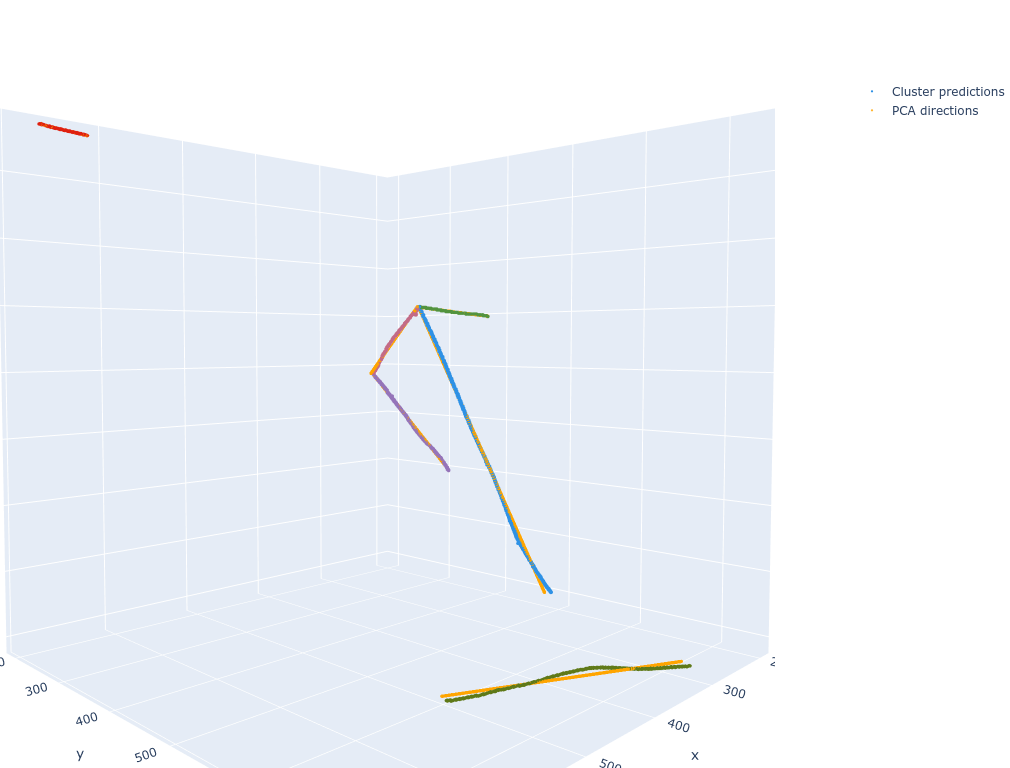

In [16]:
trace = []

trace += network_topology(data['input_data'][entry],
                         output['track_fragments'][entry],
                         #edge_index=output['frag_edge_index'][entry],
                         clust_labels=clust_ids_pred,
                         markersize=2, cmin=0, cmax=40, colorscale=plotly.colors.qualitative.Dark24)
trace[-1].name = 'Cluster predictions'

trace+= scatter_points(np.vstack(axis), markersize=2)
trace[-1].name = 'PCA directions'

fig = go.Figure(data=trace,layout=plotly_layout3d())
fig.update_layout(legend=dict(x=1.1, y=0.9))
fig.show()

You may notice that sometimes the track "deviates" from this rough PCA axis. For this reason, when we break down a track into smaller fragments to compute dQ/dx, we will re-compute a local PCA to get a better approximation of the local slope.

## Partition voxels along the principal axis

We use true endpoint information to compute the residual range along the principal axis. For this `particles_label` contains the coordinates and properties of all particles start and end points. We select the tracks (`data['particles_label'][entry][:, 4] == 1`) and end points (`data['particles_label'][entry][:, -1] == 1`).

In [18]:
track_endpoints = data['particles_label'][entry][(data['particles_label'][entry][:, -1] == 1) & (data['particles_label'][entry][:, 4] == 1)]
print(track_endpoints)


[[0.00000000e+00 4.76056654e+02 6.29536746e+02 4.78679923e+02
  1.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 5.27941520e+02 5.40280793e+02 4.03955046e+02
  1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.95760940e+02 4.85401609e+02 2.83365883e-06
  1.00000000e+00 2.00000000e+00 1.00000000e+00]
 [0.00000000e+00 5.21578860e+02 5.85000933e+02 4.82338373e+02
  1.00000000e+00 3.00000000e+00 1.00000000e+00]
 [0.00000000e+00 3.76713187e+02 4.87369143e+02 2.46740296e+02
  1.00000000e+00 7.00000000e+00 1.00000000e+00]
 [0.00000000e+00 6.89658007e+02 2.40548563e+02 7.57771753e+02
  1.00000000e+00 1.30000000e+01 1.00000000e+00]
 [0.00000000e+00 6.04737200e+02 7.03103666e+02 6.54274128e+01
  1.00000000e+00 1.40000000e+01 1.00000000e+00]]


True points information contains in the columns: batch id, x, y, z, point semantic type, particle index, and start (`0`) vs end (`1`) points.

In [19]:
step = 16 # about 5cm

**Excluding exiting muons:** If a particle exits the detector volume, the endpoint in our labels is defined at the intersection between the volume and the particle trajectory. Hence we can use the endpoint location to exclude muons that are likely exiting the volume. We use a cut of 33px (~10cm) to filter them out.

**Selecting muons** We also impose that muons in our sample need to be at least 200px (~60cm) long.

In [20]:
def get_fragments(input_data, output, step=16, track_endpoints=None, spatial_size=768, fiducial=33, min_length=200):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)
    
    local_fragments = []
    residual_range = []
    endpoints = []
    for f in output['track_fragments'][entry]:
        coords = input_data[f, 1:4]
        new_coords = pca.fit_transform(coords)
        new_coords[:, 1:] = 0.

        #
        # Require a minimum length
        #
        if new_coords[:, 0].max() - new_coords[:, 0].min() < min_length:
            continue
        
        #
        # If we want to use rough residual range, then this 
        # block makes sure we are starting from the endpoint.
        # We also recompute the residual range later to use dx estimations.
        #
        endpoint = None
        if track_endpoints is not None:
            from scipy.spatial.distance import cdist
            distances = cdist(track_endpoints[:, 1:4], coords)
            if (distances.min(axis=0) < 2).any():
                endpoint_idx, pt_idx = np.unravel_index(np.argmin(distances), distances.shape)
                endpoint = new_coords[pt_idx, 0]
                real_endpoint = track_endpoints[endpoint_idx, 1:4]

        # If None could be found, it probably means
        # that the track is exiting the volume.
        # If it was found but it is too close to the
        # boundaries, we also skip it.
        if endpoint is None or (np.abs(real_endpoint) < fiducial).any() or (np.abs(spatial_size - real_endpoint) < fiducial).any():
            continue                
        
        # Now we split the track into smaller fragments
        # of size `step` along the main PCA axis
        n = np.ceil((np.ceil(new_coords[:, 0].max()) - np.floor(new_coords[:, 0].min()))/step)
        bins = np.digitize(new_coords[:, 0], np.linspace(np.floor(new_coords[:, 0].min()), np.ceil(new_coords[:, 0].max()), int(n)))
        for b in np.unique(bins):
            local_fragments.append(f[bins == b])
            middle_pt = (new_coords[bins == b, 0].min() + new_coords[bins == b, 0].max()) / 2.
            residual_range.append(np.abs(middle_pt - endpoint))
            endpoints.append(real_endpoint)
            
    if len(endpoints):
        endpoints = np.stack(endpoints, axis=0)
            
    return local_fragments, residual_range, endpoints

In [21]:
local_fragments, residual_range, endpoints = get_fragments(input_data, output, step=step, track_endpoints=track_endpoints)

Again we can check in an event display that the result makes sense and the size of the step is appropriate:

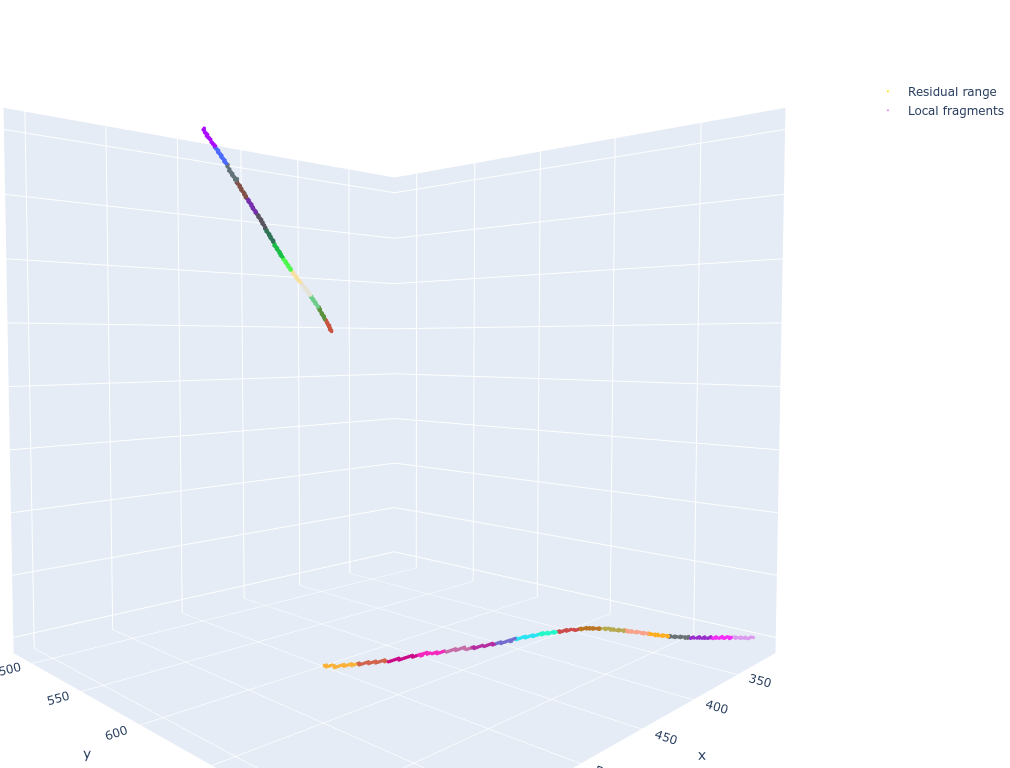

In [22]:
trace = []

trace += network_topology(data['input_data'][entry],
                         local_fragments,
                         #edge_index=output['frag_edge_index'][entry],
                         clust_labels=residual_range,
                         markersize=2, cmin=0, cmax=40, colorscale=plotly.colors.sequential.Viridis)
trace[-1].name = 'Residual range'

trace += network_topology(data['input_data'][entry],
                         local_fragments,
                         #edge_index=output['frag_edge_index'][entry],
                         clust_labels=np.arange(0, len(local_fragments)),
                         markersize=2, cmin=0, cmax=len(local_fragments), colorscale=plotly.colors.qualitative.Alphabet)
trace[-1].name = 'Local fragments'

fig = go.Figure(data=trace,layout=plotly_layout3d())
fig.update_layout(legend=dict(x=1.1, y=0.9))
fig.show()

## Local PCA and charge projection

Now for each local fragment that we just delineated, we can compute a local PCA and project the charge accordingly.

In [23]:
def compute_metrics(local_fragments, residual_range, input_data, endpoints, min_voxels=3):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)
    
    metrics = {
        "dQdx": [],
        "rough_residual_range": [],
        "dN": [],
        "dQ": [],
        "dx": []
    }
    
    final_fragments, final_endpoints = [], []
    for idx, f in enumerate(local_fragments):
        if len(f) < min_voxels:
            continue
        coords = input_data[f, 1:4]
        new_coords = pca.fit_transform(coords)
        dx = new_coords[:, 0].max() - new_coords[:, 0].min()
        dQ = input_data[f, 4].sum()
        metrics["dQdx"].append(dQ/dx)
        metrics["rough_residual_range"].append(residual_range[idx])
        metrics["dN"].append(len(f))
        metrics["dQ"].append(dQ)
        metrics["dx"].append(dx)
        final_fragments.append(f)
        final_endpoints.append(endpoints[idx])
    if len(final_endpoints):
        final_endpoints = np.stack(final_endpoints, axis=0)
    return pd.DataFrame(metrics), final_fragments, final_endpoints


In [24]:
metrics, final_fragments, final_endpoints = compute_metrics(local_fragments, residual_range, input_data, endpoints)

We can plot the fragments dQ/dx. You can see that some tracks have a much higher average dQ/dx than others - these are likely to be protons. Next we will need to select muon fragments using the true cluster labels.

The function `get_cluster_label` determines the majority label for each given fragment. We access the true cluster id first from `clust_label`. This cluster id is an index of the `particles` data product. This allows us to retrieve the particle corresponding to this true cluster:

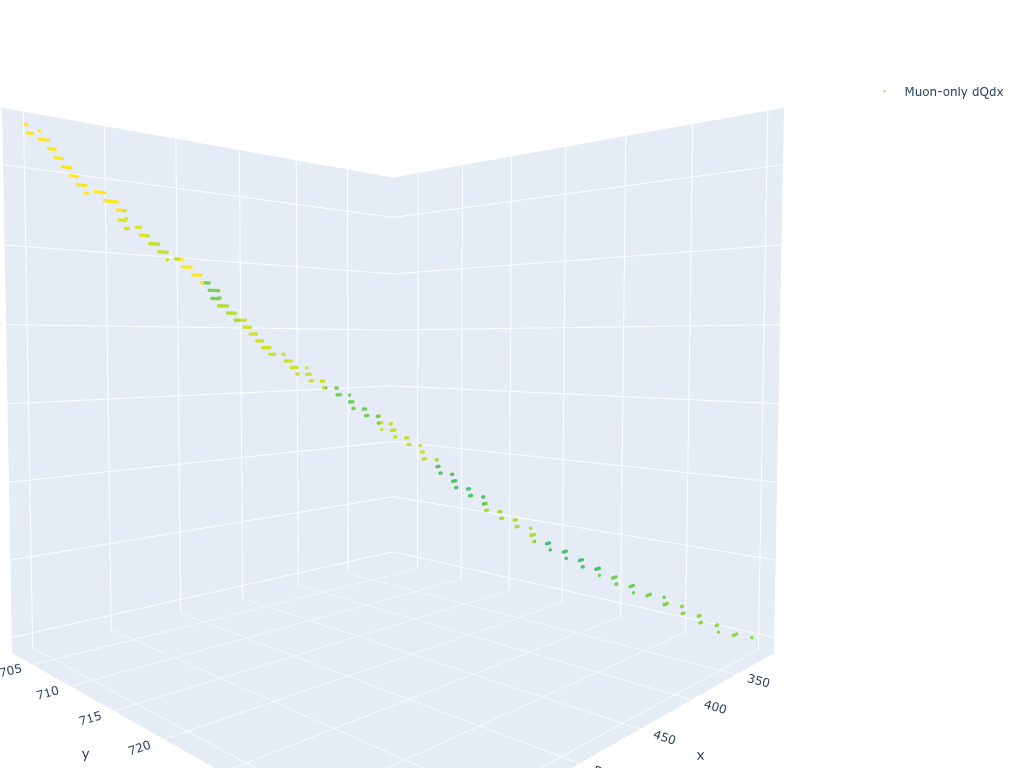

In [25]:
trace = []

true_cluster_id =  get_cluster_label(clust_label, final_fragments, column=6)
true_pdg = np.array([particles[idx].pdg_code() for idx in true_cluster_id])
muons = (true_pdg == 13) | (true_pdg == -13)

trace += network_topology(data['input_data'][entry],
                         np.array(final_fragments, dtype=object)[muons],
                         #edge_index=output['frag_edge_index'][entry],
                         clust_labels=np.array(metrics["dQdx"])[muons],
                         markersize=2, cmin=0, cmax=0.8, colorscale=plotly.colors.sequential.Viridis)
trace[-1].name = 'Muon-only dQdx'

fig = go.Figure(data=trace,layout=plotly_layout3d())
fig.update_layout(legend=dict(x=1.1, y=0.9))
fig.show()

And for clarity, let's also visualize exclusively the true muons:

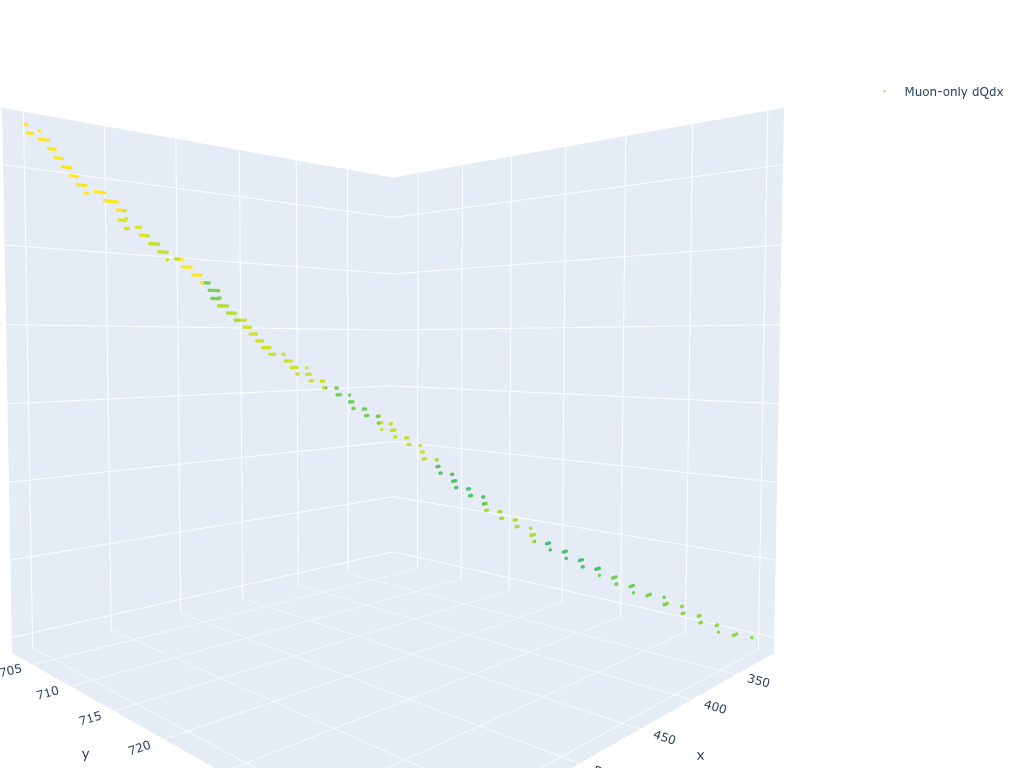

In [26]:
trace = []

true_cluster_id =  get_cluster_label(clust_label, final_fragments, column=6)
true_pdg = np.array([particles[idx].pdg_code() for idx in true_cluster_id])
muons = (true_pdg == 13) | (true_pdg == -13)

trace += network_topology(data['input_data'][entry],
                         np.array(final_fragments, dtype=object)[muons],
                         #edge_index=output['frag_edge_index'][entry],
                         clust_labels=np.array(metrics["dQdx"])[muons],
                         markersize=2, cmin=0, cmax=0.8, colorscale=plotly.colors.sequential.Viridis)
trace[-1].name = 'Muon-only dQdx'

fig = go.Figure(data=trace,layout=plotly_layout3d())
fig.update_layout(legend=dict(x=1.1, y=0.9))
fig.show()

## Computing residual range

To be more precise, we will use the local PCAs to compute the residual range (distance to the end point of the muon). We identify fragments that belong to the same true muons, find a corresponding true endpoint and order the fragments accordingly. Residual range is computed as an incremental sum of the local dx computed with a local PCA.

In [27]:
def compute_residual_range(input_data, clust_label, track_endpoints, metrics, final_fragments, endpoints,
                          spatial_size=768, fiducial=33):
    from scipy.spatial.distance import cdist
    
    true_cluster_ids = get_cluster_label(clust_label, final_fragments, column=6)
    fragments_batch_ids = get_cluster_batch(clust_label, final_fragments)

    final_fragments = np.array([np.array(f, dtype=int) for f in final_fragments], dtype=object)
    residual_range = - np.ones((len(final_fragments),))
    # Loop over events in current batch
    for b in fragments_batch_ids:
        batch_mask = fragments_batch_ids == b
        # Loop over track clusters in this event
        for idx in np.unique(true_cluster_ids[batch_mask]):
            track_fragments = final_fragments[batch_mask][true_cluster_ids[batch_mask] == idx]
            endpoint = endpoints[batch_mask][true_cluster_ids[batch_mask] == idx][0]
                
            # Now order fragments per distance to endpoint
            # We want to start from the fragment closest to the endpoint
            # and go from there.
            init_perm = np.argsort(metrics["rough_residual_range"][batch_mask][true_cluster_ids[batch_mask] == idx].values)
            order = []
            total_d = 0 # Keep track of total distance by accumulating dx
            # Loop over segments, starting with the one closest to the endpoint.
            for f_idx, f in enumerate(track_fragments[init_perm]):
                distances = cdist(input_data[np.array(f).astype(int), 1:4], [endpoint])
                order.append(total_d + (distances.max() + distances.min())/2)
                total_d += (distances.max() + distances.min())/2 
                # At each step we change the "endpoint" to the other end of the segment.
                endpoint = input_data[np.array(f).astype(int), 1:4][np.argmax(distances.reshape((-1,)))]

            # Now we want to re-order according to the new distances we just computed.
            perm = np.argsort(np.array(order)[np.argsort(init_perm)])

            current_distance = 0.
            for f_idx, f in enumerate(track_fragments[perm]):
                dx = metrics["dx"][batch_mask][true_cluster_ids[batch_mask] == idx].values[perm][f_idx]
                current_distance += dx
                
                where = np.where(batch_mask)[0][true_cluster_ids[batch_mask] == idx][perm][f_idx]
                residual_range[where] = current_distance
                
    metrics["residual_range"] = residual_range
    metrics = metrics[metrics["residual_range"] > -1]
    return metrics

In [28]:
metrics = compute_residual_range(input_data, clust_label, track_endpoints, metrics, final_fragments, final_endpoints)

In [29]:
metrics

dQdx  rough_residual_range  dN         dQ         dx  residual_range
0   0.670820            215.805913  24  10.309288  15.368193      216.321492
1   0.597403            199.857614  24   9.048809  15.146910      200.953298
2   0.744279            183.909315  26  11.447610  15.380796      185.806389
3   0.714573            167.728744  27  11.185344  15.653182      170.425593
4   0.754118            151.548173  26  11.600599  15.383000      154.772411
5   0.686613            135.487416  25  10.565251  15.387485      139.389411
6   0.588963            119.419302  25   9.056611  15.377209      124.001926
7   0.800850            103.011635  25  12.862858  16.061512      108.624717
8   0.581262             86.603967  24   8.935924  15.373306       92.563205
9   0.648233             70.663025  24   9.829471  15.163492       77.189898
10  0.757134             54.509702  25  11.995086  15.842743       62.026406
11  0.788163             38.221849  22  12.132432  15.393299       46.183663
12  0.672643             22.161093  25  10.422913  15.495470       30.790365
13  2.572521              6.205436  24  39.346442  15.294895       15.294895
14  0.666333            293.947044  23  10.711216  16.074872      289.697333
15  0.628702            277.227425  24  10.067414  16.013023      273.622461
16  0.563233            260.067082  21   9.434403  16.750434      257.609438
17  0.701079            243.709578  24  11.080658  15.805160      240.859004
18  0.578294            226.803851  24   9.493893  16.417061      225.053844
19  0.735342            209.637664  27  12.227698  16.628582      208.636782
20  0.625547            192.748510  24  10.200695  16.306840      192.008200
21  0.745209            175.950282  23  11.657073  15.642693      175.701360
22  0.740637            159.017254  20  12.079103  16.309078      160.058666
23  0.748310            142.282649  20  11.446083  15.295906      143.749588
24  0.705841            125.593507  20  11.484588  16.270797      128.453682
25  0.635911            108.571141  20  10.270491  16.150844      112.182885
26  0.850691             91.548774  19  13.843337  16.273053       96.032042
27  0.729194             74.814170  19  11.171758  15.320690       79.758989
28  0.763090             58.079565  22  12.417615  16.272811       64.438299
29  0.896930             41.011736  19  14.462509  16.124460       48.165488
30  0.950666             24.717855  21  15.673620  16.486996       32.041028
31  1.693098              7.768253  21  26.334498  15.554032       15.554032

## dQ/dx residual plot

We need to repeat this analysis with a bit more statistics to get an interesting residual plot.

In [30]:
metrics = None
muon_label = 2
step = 16 # about 5cm

for idx in tqdm(range(300)):
    data, output = hs.trainer.forward(hs.data_io_iter)
    
    for entry in range(batch_size):
        clust_label = data['cluster_label'][entry]
        input_data = data['input_data'][entry]
        particle_label = data['particles_label'][entry]
        particles = data['particles_asis'][entry]
        
        # Bin tracks into smaller fragments
        track_endpoints = particle_label[(particle_label[:, -1] == 1) & (particle_label[:, 4] == 1)]
        local_fragments, residual_range, endpoints = get_fragments(input_data, output, step=step, track_endpoints=track_endpoints)
        
        if len(local_fragments) == 0:
            continue
            
        # Get true PID label to select true muons
        true_cluster_id =  get_cluster_label(clust_label, local_fragments, column=6)
        true_pdg = np.array([particles[idx].pdg_code() for idx in true_cluster_id])
        muons = (true_pdg == 13) | (true_pdg == -13)
        
        # For each smaller fragment compute metrics
        result, final_fragments, final_endpoints = compute_metrics(np.array(local_fragments, dtype=object)[muons], np.array(residual_range)[muons], input_data,  endpoints[muons])
        
        if len(final_fragments) == 0:
            continue
            
        # Refine residual range computation
        result = compute_residual_range(input_data, clust_label, track_endpoints, result, final_fragments, final_endpoints)
        
        # Store batch id etc
        n = len(result)
        result["entry"] = np.ones((n,)) * entry
        result["index"] = np.ones((n,)) * idx
        
        if metrics is None:
            metrics = result
        else:
            metrics = pd.concat([metrics, result])

  0%|          | 0/300 [00:00<?, ?it/s]

76246


Text(0, 0.5, 'Muon dQ/dx')

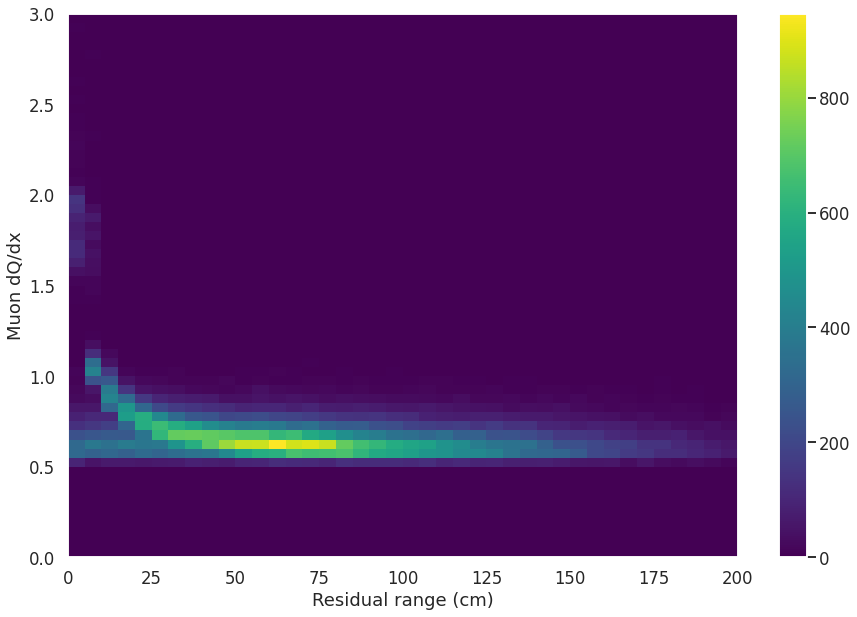

In [31]:
print(len(metrics))
plt.hist2d(metrics["residual_range"]*0.3, metrics["dQdx"],
          range=[[0, 200], [0., 3]], bins=[40, 60],
          cmap="viridis")
plt.colorbar()
plt.xlabel("Residual range (cm)")
plt.ylabel("Muon dQ/dx")

## Sanity checks

### Fragments dx distribution

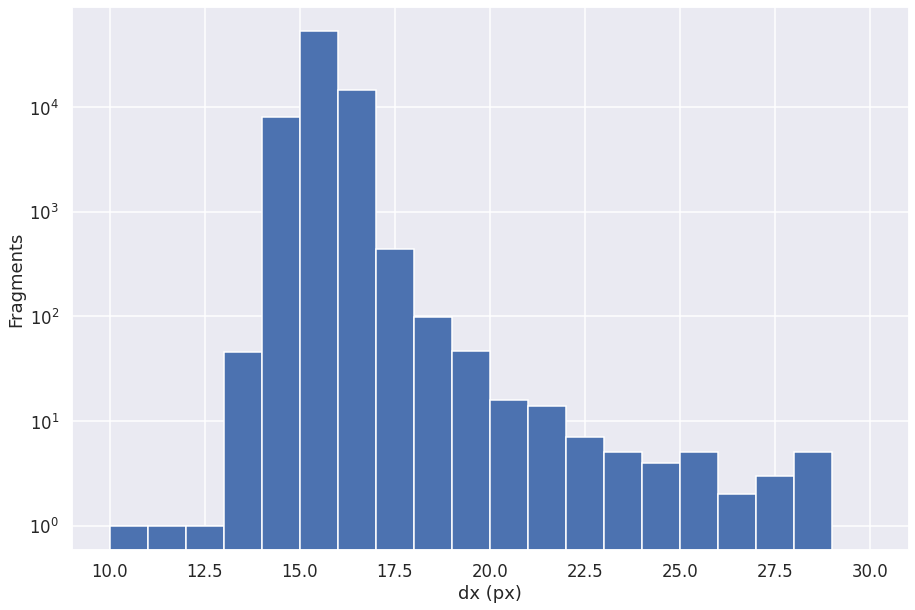

In [32]:
plt.hist(metrics["dx"], range=[10, 30], bins=20)
plt.xlabel("dx (px)")
plt.ylabel("Fragments")
plt.yscale('log')

### Fragments dN distribution

Text(0, 0.5, 'Fragments')

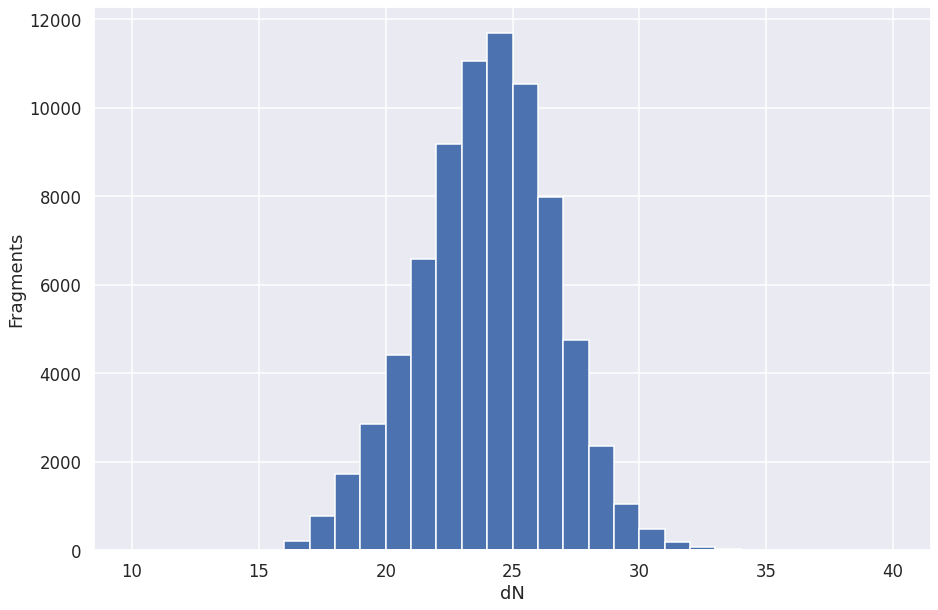

In [33]:
plt.hist(metrics["dN"], range=[10, 40], bins=30)
plt.xlabel("dN")
plt.ylabel("Fragments")

### Fragments dQ/dx distribution

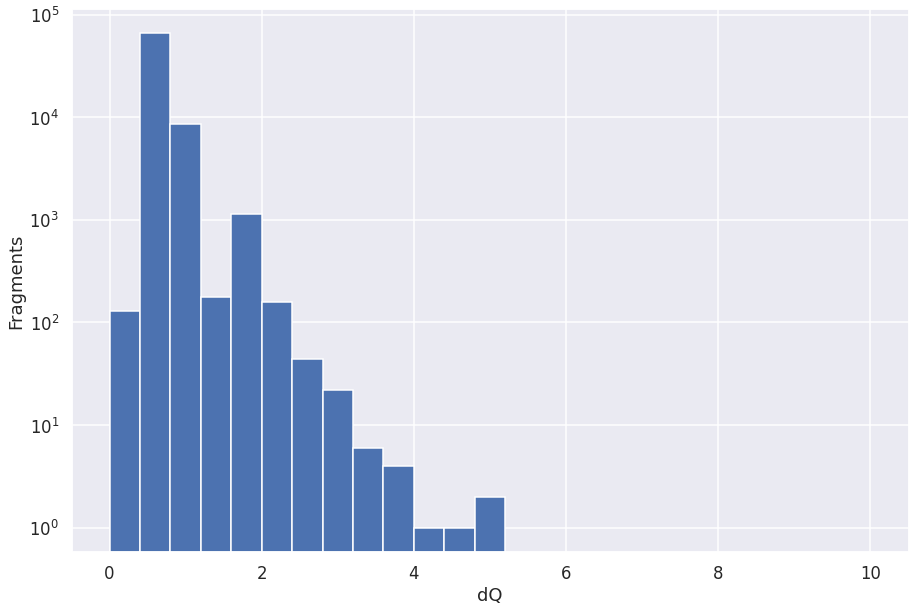

In [34]:
plt.hist(metrics["dQdx"], range=[0, 10], bins=25)
plt.xlabel("dQ")
plt.ylabel("Fragments")
plt.yscale('log')

In [ ]:
track_endpoints = data['particles_label'][entry][(data['particles_label'][entry][:, -1] == 1) & (data['particles_label'][entry][:, 4] == 1)]
print(track_endpoints)

In [ ]:
step = 16 # about 5cm

In [ ]:
def get_fragments(input_data, output, step=16, track_endpoints=None, spatial_size=768, fiducial=33, min_length=200):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)
    
    local_fragments = []
    residual_range = []
    endpoints = []
    for f in output['track_fragments'][entry]:
        coords = input_data[f, 1:4]
        new_coords = pca.fit_transform(coords)
        new_coords[:, 1:] = 0.

        #
        # Require a minimum length
        #
        if new_coords[:, 0].max() - new_coords[:, 0].min() < min_length:
            continue
        
        #
        # If we want to use rough residual range, then this 
        # block makes sure we are starting from the endpoint.
        # We also recompute the residual range later to use dx estimations.
        #
        endpoint = None
        if track_endpoints is not None:
            from scipy.spatial.distance import cdist
            distances = cdist(track_endpoints[:, 1:4], coords)
            if (distances.min(axis=0) < 2).any():
                endpoint_idx, pt_idx = np.unravel_index(np.argmin(distances), distances.shape)
                endpoint = new_coords[pt_idx, 0]
                real_endpoint = track_endpoints[endpoint_idx, 1:4]

        # If None could be found, it probably means
        # that the track is exiting the volume.
        # If it was found but it is too close to the
        # boundaries, we also skip it.
        if endpoint is None or (np.abs(real_endpoint) < fiducial).any() or (np.abs(spatial_size - real_endpoint) < fiducial).any():
            continue                
        
        # Now we split the track into smaller fragments
        # of size `step` along the main PCA axis
        n = np.ceil((np.ceil(new_coords[:, 0].max()) - np.floor(new_coords[:, 0].min()))/step)
        bins = np.digitize(new_coords[:, 0], np.linspace(np.floor(new_coords[:, 0].min()), np.ceil(new_coords[:, 0].max()), int(n)))
        for b in np.unique(bins):
            local_fragments.append(f[bins == b])
            middle_pt = (new_coords[bins == b, 0].min() + new_coords[bins == b, 0].max()) / 2.
            residual_range.append(np.abs(middle_pt - endpoint))
            endpoints.append(real_endpoint)
            
    if len(endpoints):
        endpoints = np.stack(endpoints, axis=0)
            
    return local_fragments, residual_range, endpoints

In [ ]:
local_fragments, residual_range, endpoints = get_fragments(input_data, output, step=step, track_endpoints=track_endpoints)

In [ ]:
trace = []

trace += network_topology(data['input_data'][entry],
                         local_fragments,
                         #edge_index=output['frag_edge_index'][entry],
                         clust_labels=residual_range,
                         markersize=2, cmin=0, cmax=40, colorscale=plotly.colors.sequential.Viridis)
trace[-1].name = 'Residual range'

trace += network_topology(data['input_data'][entry],
                         local_fragments,
                         #edge_index=output['frag_edge_index'][entry],
                         clust_labels=np.arange(0, len(local_fragments)),
                         markersize=2, cmin=0, cmax=len(local_fragments), colorscale=plotly.colors.qualitative.Alphabet)
trace[-1].name = 'Local fragments'

fig = go.Figure(data=trace,layout=plotly_layout3d())
fig.update_layout(legend=dict(x=1.1, y=0.9))

iplot(fig)

In [ ]:
def compute_metrics(local_fragments, residual_range, input_data, endpoints, min_voxels=3):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)
    
    metrics = {
        "dQdx": [],
        "rough_residual_range": [],
        "dN": [],
        "dQ": [],
        "dx": []
    }
    
    final_fragments, final_endpoints = [], []
    for idx, f in enumerate(local_fragments):
        if len(f) < min_voxels:
            continue
        coords = input_data[f, 1:4]
        new_coords = pca.fit_transform(coords)
        dx = new_coords[:, 0].max() - new_coords[:, 0].min()
        dQ = input_data[f, 4].sum()
        metrics["dQdx"].append(dQ/dx)
        metrics["rough_residual_range"].append(residual_range[idx])
        metrics["dN"].append(len(f))
        metrics["dQ"].append(dQ)
        metrics["dx"].append(dx)
        final_fragments.append(f)
        final_endpoints.append(endpoints[idx])
    if len(final_endpoints):
        final_endpoints = np.stack(final_endpoints, axis=0)
    return pd.DataFrame(metrics), final_fragments, final_endpoints

In [ ]:
metrics, final_fragments, final_endpoints = compute_metrics(local_fragments, residual_range, input_data, endpoints)